# Poetry Generator

The purpose of this notebook is to explore the power of LLM and RNN models to generate poetry from using song lyrics as a dataset. The song datasets I plan to use come from a github repo that has various lyrics from many artists written in txt files.
* https://github.com/laxmimerit/poetry-data

### Resources
This has been done before, and the article below touches on how it was done for a reference.

* https://kgptalkie.medium.com/poetry-generation-using-tensorflow-keras-and-lstm-75c4e4b7f07e
* https://www.kaggle.com/code/paultimothymooney/poetry-generator-rnn-markov/notebook
* https://www.kaggle.com/code/shivamb/beginners-guide-to-text-generation-using-lstms
* https://www.tensorflow.org/text/tutorials/text_generation

## Setup

Need to figure out if I'm on google colab or on local. This will determine which commands need to be ran and how to setup the CPU/GPU being used.

Additionally, if on google colab, then I will need to install my personal repository, [py-learning-toolbox](https://github.com/bkubick/py-learning-toolbox) as a package.

In [2]:
# Determining if on google colab
try:
  from google import colab
  on_colab = True
except Exception:
  on_colab = False

on_colab

False

In [3]:
# Installing my personal repo that contains all my utils as a package
if on_colab:
  !nvidia-smi -L
  !pip install py-learning-toolbox@git+https://github.com/bkubick/py-learning-toolbox.git
  !pltb_setup_project .

## Imports

In [4]:
import datetime
import logging
import random
import re
import string
import sys
import typing

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from py_learning_toolbox import ml_toolbox
from py_learning_toolbox import data_toolbox
from py_learning_toolbox import performance_toolbox
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
import tensorflow_hub as hub

## Environment

Setting up the environment and analyzing the various information associated with this notebook.

In [5]:
print(f'Notebook last run (end-to-end): {datetime.datetime.now()}')

Notebook last run (end-to-end): 2023-10-02 19:53:11.231725


In [6]:
tf.__version__

'2.13.0'

In [7]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [8]:
# Setting up logging
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Global Constants

In [9]:
RANDOM_SEED = 27

## Helpers
Defining helper functions to make split certain functionality out of tasks.

In [10]:
def download_preprocess_and_structure_data(url_by_artist: typing.Dict[str, str]) -> pd.DataFrame:
    """ Downloads and structures the data into a pandas DF.

        Args:
            url_by_artist (Dict[str, str]): the url to grab data from for the corresponding artist.

        Returns:
            (DataFrame) the corresponding structured dataframe.
    """
    all_data = []
    pattern = re.compile(r'\s+')

    for artist in url_by_artist:
        sentences = data_toolbox.read_txt_file_from_url(url_by_artist[artist], delimiter='\n')

        for sentence in sentences:
            cleaned_sentence = ml_toolbox.preprocessing.language.clean_text(sentence)

            if len(cleaned_sentence) > 0:
                all_data.append({'artist': artist, 'sentence': cleaned_sentence})

    return pd.DataFrame(all_data)

In [13]:
def generate_text(seed_text: str,
                  num_words_to_create: int,
                  model: tf.keras.models.Model,
                  one_hot: OneHotEncoder) -> str:
    """ Generates a sentence from the seed text with the designated model and encoder mapper.

        Args:
            seed_text (str): the starting text for the sentence to be generated.
            num_words_to_create (int): how many words to add.
            model (Model): the model to use to generate the text.
            one_hot (OneHotEncoder): the encoder used with the model to convert numerical indices to text.

        Returns:
            (str) the generated text.
    """
    generated_text = seed_text

    for _ in range(num_words_to_create):
        pred_probs = model.predict([generated_text], verbose=0)
        pred_word_index = tf.argmax(pred_probs, axis=1)[0]
        pred_probs[0][pred_word_index] = 1  # Due to the size of the word list, rounding doesn't always gurantee a selected word
        pred_vector = tf.round(pred_probs)
        predicted_word = str(one_hot_encoder.inverse_transform(pred_vector)[0][0], encoding='utf-8')
        generated_text += f' {predicted_word}'

    return generated_text

## Downloading, Analyzing, & Creating Datasets

The data I plan to use comes directly from the raw txt file from the links below.

* https://github.com/laxmimerit/poetry-data

For this notebook, I am going to limit my datasets to the following artists:

* [The Beatles](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt)
* [Adele](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt)
* [Bob Dylan](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt)
* [Disney](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/disney.txt)
* [Drake](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/drake.txt)
* [Dr. Seuss](https://raw.githubusercontent.com/laxmimerit/poetry-data/master/dr-seuss.txt)

### Constants

In [14]:
DATA_URLS = {
    'beatles': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/beatles.txt',
    'adele': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/adele.txt',
    'bob_dylan': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/bob-dylan.txt',
    # 'disney': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/disney.txt',
    # 'drake': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/drake.txt',
    # 'dr_seuss': 'https://raw.githubusercontent.com/laxmimerit/poetry-data/master/dr-seuss.txt',
}

### Downloading & Analyzing Data

In [15]:
data_df = download_preprocess_and_structure_data(DATA_URLS)
data_df

,artist,sentence
0,beatles,yesterday all my troubles seemed so far away
1,beatles,now it looks as though theyre here to stay
2,beatles,oh i believe in yesterday suddenly im not half...
3,beatles,theres a shadow hanging over me
4,beatles,oh yesterday came suddenly why she had to go i...
...,...,...
9454,bob_dylan,shine your light shine your light on me
9455,bob_dylan,shine your light shine your light on me
9456,bob_dylan,shine your light shine your light on me
9457,bob_dylan,ya know i just couldn’t make it by myself


In [16]:
data = tf.convert_to_tensor(data_df.sentence.to_numpy())
data[:5]

<tf.Tensor: shape=(5,), dtype=string, numpy=
array([b'yesterday all my troubles seemed so far away',
       b'now it looks as though theyre here to stay',
       b'oh i believe in yesterday suddenly im not half the man i used to be',
       b'theres a shadow hanging over me',
       b'oh yesterday came suddenly why she had to go i dont know she wouldnt say'],
      dtype=object)>

In [17]:
# Seeing the vocab
word_counts = ml_toolbox.analysis.language.get_word_counts(data)

len(word_counts)

5683

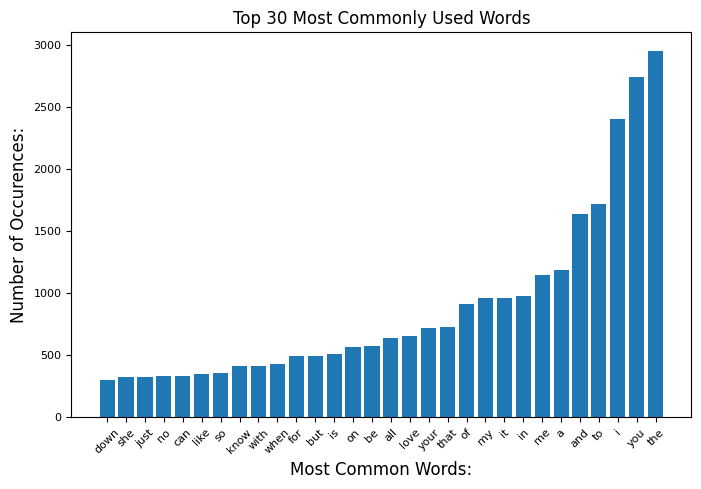

In [18]:
ml_toolbox.analysis.language.plot_words_counts(word_counts, most_common=True, n=30)

### Token Embeddings

In [19]:
# Find average number of tokens
sent_lens = [len(i.split()) for i in data_df.sentence.to_numpy()]
round(sum(sent_lens) / len(data))

8

In [20]:
max(sent_lens)

34

In [21]:
# How long of a sentence covers 98% of the examples?
int(np.percentile(sent_lens, 98))

16

In [23]:
# Setup text vectorization params
max_vocab_length = 10000  # Max words to have in our vocab
max_length = 16

In [24]:
# Setting up a text vectorization layer (tokenization)
text_vectorizer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=max_vocab_length,  # How many words in the vocabulary
    output_sequence_length=max_length)  # Padds (adds 0's to end of number) to make all the same length

# Adapt the vectorizer to the training data
text_vectorizer.adapt(data)

In [25]:
# Getting the words in the vocab from the training data
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
least_common_5_words = words_in_vocab[-5:]

len(words_in_vocab), top_5_words, least_common_5_words

(5685,
 ['', '[UNK]', 'the', 'you', 'i'],
 ['abel', 'abeatin’', 'abandon', 'aaaaahhhhhhhhhh', '61”'])

In [26]:
# Setting up the Embedding layer
token_embedding = tf.keras.layers.Embedding(input_dim=len(words_in_vocab),
                                            output_dim=128,  # GPU's work well when number is divisible by 8
                                            mask_zero=True,
                                            name='token_embedding')
token_embedding

In [27]:
# Testing out an example sentence
target_sentence = random.choice(data)

# Looking at the steps of tokenization
print(f'Sentence before vectorization: \n {target_sentence}')
vectorized_sentence = text_vectorizer([target_sentence])
print(f'Sentence after vectorization: \n {vectorized_sentence}')
embedded_sentence = token_embedding(vectorized_sentence)
print(f'Sentence after embedding: \n {embedded_sentence}')
print(f'Embedded sentence shape: {embedded_sentence.shape}')

Sentence before vectorization: 
 b'nobodys perfect'
Sentence after vectorization: 
 [[1481 1263    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]
Sentence after embedding: 
 [[[ 0.03057278 -0.02003031  0.04700103 ...  0.04549963 -0.02336981
   -0.02854913]
  [ 0.03853912  0.02280879 -0.04097828 ...  0.02999124 -0.03025039
   -0.0381246 ]
  [ 0.00164742  0.00097617  0.00130212 ...  0.01946975 -0.00060182
    0.04622016]
  ...
  [ 0.00164742  0.00097617  0.00130212 ...  0.01946975 -0.00060182
    0.04622016]
  [ 0.00164742  0.00097617  0.00130212 ...  0.01946975 -0.00060182
    0.04622016]
  [ 0.00164742  0.00097617  0.00130212 ...  0.01946975 -0.00060182
    0.04622016]]]
Embedded sentence shape: (1, 16, 128)


### Character Embeddings

In [40]:
# TODO

### Creating Training Data

In [30]:
X, y = ml_toolbox.preprocessing.language.create_sequenced_data_labels_from_sentences(data_df.sentence.to_numpy())
X[:3], y[:3]

(<tf.Tensor: shape=(3,), dtype=string, numpy=array([b'yesterday', b'yesterday all', b'yesterday all my'], dtype=object)>,
 <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'all', b'my', b'troubles'], dtype=object)>)

In [31]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
one_hot_encoder.fit_transform(tf.reshape(text_vectorizer.get_vocabulary(), (-1,1)))

y_one_hot_encoded = one_hot_encoder.transform(tf.reshape(y, (-1, 1)))

In [32]:
y_one_hot_encoded.shape

(62035, 5685)

### Creating Datasets

In [33]:
train_dataset = data_toolbox.datasets.generate_dataset_from_data([X], y_one_hot_encoded)
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None),), TensorSpec(shape=(None, 5685), dtype=tf.float64, name=None))>

## Experiments

I am going to run a handful of experiments to try and generate poems, as listed below:

* Experiment-0 (Baseline): LSTM w/ Token Embeddings
* Experiment-1: Universal Sentence Encoder w/ Token Embeddings
* Experiment-2: Conv1D w/ Token Embeddings
* Experiment-3: Bidirectional LSTM w/ Token Embeddings
* Experiment-4: LSTM w/ Character Embeddings
* Experiment-5: LSTM w/ Character Embeddings + Token Embeddings

### Constants

In [34]:
TOTAL_WORDS = len(words_in_vocab)
UNIVERSAL_SENTENCE_ENCODER_URL = 'https://tfhub.dev/google/universal-sentence-encoder/4'

### Experiment-0 (Baseline): LSTM with Token Embeddings

For a baseline, going to use a very simple model with only a single LSTM layer.

In [35]:
# Constants
model_0_name = 'model_0_simple_lstm'

In [36]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)

x = text_vectorizer(inputs)  # Turn the input text into numbers
x = token_embedding(x)  # Embed the text
x = tf.keras.layers.LSTM(64)(x)

outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_0 = tf.keras.models.Model(inputs, outputs, name=model_0_name)
model_0.summary()

Model: "model_0_simple_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 16)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 16, 128)           727680    
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 5685)              369525    
                                                                 
Total params: 1146613 (4.37 MB)
Trainable param

In [37]:
model_0.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [38]:
model_0.fit(train_dataset, epochs=10)

Epoch 1/10
1939/1939 [==============================] - 24s 12ms/step - loss: 6.6966 - accuracy: 0.0472
Epoch 2/10
1939/1939 [==============================] - 23s 12ms/step - loss: 6.0394 - accuracy: 0.0638
Epoch 3/10
1939/1939 [==============================] - 24s 13ms/step - loss: 5.5929 - accuracy: 0.0888
Epoch 4/10
1939/1939 [==============================] - 24s 12ms/step - loss: 5.2459 - accuracy: 0.1140
Epoch 5/10
1939/1939 [==============================] - 23s 12ms/step - loss: 4.9357 - accuracy: 0.1380
Epoch 6/10
1939/1939 [==============================] - 22s 12ms/step - loss: 4.6571 - accuracy: 0.1651
Epoch 7/10
1939/1939 [==============================] - 23s 12ms/step - loss: 4.4003 - accuracy: 0.1929
Epoch 8/10
1939/1939 [==============================] - 23s 12ms/step - loss: 4.1682 - accuracy: 0.2207
Epoch 9/10
1939/1939 [==============================] - 23s 12ms/step - loss: 3.9550 - accuracy: 0.2484
Epoch 10/10
1939/1939 [==============================] - 23s 12m

In [39]:
print(generate_text('Love is true', 8, model_0, one_hot_encoder))
print(generate_text('Tomorrow comes', 8, model_0, one_hot_encoder))
print(generate_text('Yesterday we', 8, model_0, one_hot_encoder))
print(generate_text('But today', 8, model_0, one_hot_encoder))

Love is true love you love you love you love you
Tomorrow comes from the streets child of clay on the
Yesterday we could have heard me to be the way
But today is brief and i need a shot of


### Experiment-1: Universal Sentence Encoder with Token Embeddings

In [33]:
# Constants
model_1_name = 'model_1_use'

In [37]:
# Build Model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = hub.KerasLayer(UNIVERSAL_SENTENCE_ENCODER_URL,
                                      trainable=False,
                                      name='USE')(inputs)
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_embedding)
outputs = tf.keras.layers.Dense(TOTAL_WORDS, activation='softmax')(x)

model_1 = tf.keras.models.Model(inputs, outputs, name=model_1_name)
model_1.summary()

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 480.00MB
INFO:absl:Downloading https://tfhub.dev/google/universal-sentence-encoder/4: 970.00MB
INFO:absl:Downloaded https://tfhub.dev/google/universal-sentence-encoder/4, Total size: 987.47MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/google/universal-sentence-encoder/4'.
INFO:absl:Fingerprint not found. Saved model loading will continue.
Model: "model_1_use"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 128)               65664 

In [38]:
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.legacy.Adam(),
                metrics=['accuracy'])

In [39]:
model_1.fit(train_dataset, epochs=10)

Epoch 1/10
3680/3680 [==============================] - 19s 5ms/step - loss: 6.6677 - accuracy: 0.0508
Epoch 2/10
3680/3680 [==============================] - 19s 5ms/step - loss: 5.9771 - accuracy: 0.0651
Epoch 3/10
3680/3680 [==============================] - 18s 5ms/step - loss: 5.5876 - accuracy: 0.0757
Epoch 4/10
3680/3680 [==============================] - 19s 5ms/step - loss: 5.2036 - accuracy: 0.0894
Epoch 5/10
3680/3680 [==============================] - 19s 5ms/step - loss: 4.8384 - accuracy: 0.1059
Epoch 6/10
3680/3680 [==============================] - 19s 5ms/step - loss: 4.5109 - accuracy: 0.1302
Epoch 7/10
3680/3680 [==============================] - 19s 5ms/step - loss: 4.2435 - accuracy: 0.1564
Epoch 8/10
3680/3680 [==============================] - 19s 5ms/step - loss: 4.0334 - accuracy: 0.1869
Epoch 9/10
3680/3680 [==============================] - 20s 5ms/step - loss: 3.8748 - accuracy: 0.2169
Epoch 10/10
3680/3680 [==============================] - 19s 5ms/step - l

In [40]:
print(generate_text('Love is true', 8, model_1, one_hot_encoder))
print(generate_text('Tomorrow comes', 8, model_1, one_hot_encoder))
print(generate_text('Yesterday we', 8, model_1, one_hot_encoder))
print(generate_text('But today', 8, model_1, one_hot_encoder))

Love is true because you and you and you you and
Tomorrow comes on this this is the the the the
Yesterday we in in a a house clubs on party
But today the wet in a cup in in the


### Experiment-2: Conv1D with Token Embeddings

In [43]:
# Constants
model_2_name = 'model_2_use_lstm'

### Experiment-3: Bidirectional LSTM with Token Embeddings

### Experiment-4: LSTM with Character Embeddings

### Experiment-5: LSTM with Character Embeddings & Token Embeddings